In [3]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_3/'

In [4]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import data_loader

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.regressor import ResidualsPlot, PredictionError

import shap
plt.rcParams['savefig.facecolor']='white'

/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [21]:
reduced_terms_list, df_model = data_loader(output_filepath)
df_model['year'] = df_model.year.astype(str)
df_model = df_model.groupby('country').filter(lambda x: len(x)>1)

In [22]:
controls = ['log_GFCF', 'log_wkn_population']
x_labels = controls + reduced_terms_list + ['year','country']
y_label = 'log_gdp'

In [23]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_model[x_labels], df_model[y_label], test_size=0.33, random_state=42, stratify=df_model[['country']] )

## Lasso

In [29]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('ElasticNet', ElasticNet())])

param_grid = [
  {'ElasticNet__alpha': np.arange(0.1,0.9,0.1), 
   'ElasticNet__l1_ratio': np.arange(0.1,0.9,0.1),
   'ElasticNet__fit_intercept':[True],
   'ElasticNet__normalize': [True],
   'ElasticNet__selection':['cyclic', 'random'],
   'ElasticNet__max_iter':[10000]}]

reg = GridSearchCV(regressor, param_grid, scoring='r2')
reg.fit(X_train, y_train)
    

print('Best estimator alpha =', reg.best_estimator_['ElasticNet'].alpha)
print('Best estimator l1_ratio =', reg.best_estimator_['ElasticNet'].l1_ratio)
print('Best estimator intercept =', reg.best_estimator_['ElasticNet'].intercept_)

df_results = pd.DataFrame({'variable':controls + reduced_terms_list + list(reg.best_estimator_['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(['year','country'])), 
              'coefficient':reg.best_estimator_['ElasticNet'].coef_}).sort_values(by='coefficient', ascending=False)

df_results

Best estimator alpha = 0.1
Best estimator l1_ratio = 0.1
Best estimator intercept = 10.688826041579603


,variable,coefficient
79,country_USA,0.052583
3,financial_authorities,0.027156
51,country_JPN,0.025819
5,goods_authorities,0.025344
29,country_CHN,0.022899
...,...,...
37,country_EST,-0.015488
48,country_ISL,-0.022647
25,country_BRN,-0.024181
53,country_KHM,-0.036159


In [16]:
df_results

,variable,coefficient
79,country_USA,0.052583
3,financial_authorities,0.027156
51,country_JPN,0.025819
5,goods_authorities,0.025344
29,country_CHN,0.022899
...,...,...
37,country_EST,-0.015488
48,country_ISL,-0.022647
25,country_BRN,-0.024181
53,country_KHM,-0.036159


<AxesSubplot:xlabel='variable'>

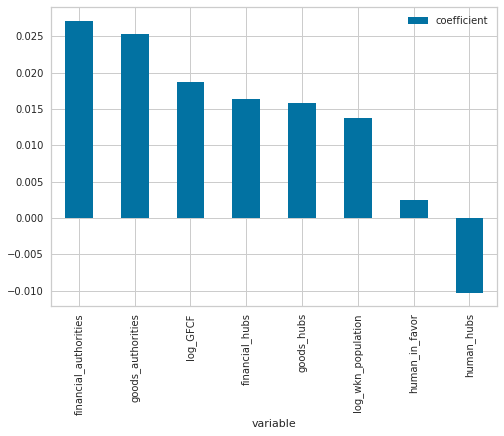

In [15]:
df_results[~df_results.variable.str.contains('country|year')].set_index('variable').plot(kind='bar')

In [8]:
df_results[df_results.variable.str.contains('country')]

,variable,coefficient
79,country_USA,0.052583
51,country_JPN,0.025819
29,country_CHN,0.022899
34,country_DEU,0.015671
39,country_FRA,0.010878
...,...,...
37,country_EST,-0.015488
48,country_ISL,-0.022647
25,country_BRN,-0.024182
53,country_KHM,-0.036159


In [9]:
reg.score(X_test, y_test)

0.12080246762748148

## LightGBM

In [10]:
# Transform
# Impute numeric values with median 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median',add_indicator=True)),
    ('transformer', FunctionTransformer(None, validate=False))])

# Impute categorical features with 'missing' and one-hot-encode them
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value='missing',
                              add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine all transformers in a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=["float64", "int64"])),
        ('cat', categorical_transformer, make_column_selector(dtype_include=["object"])),])

regressor = Pipeline(steps=[ ('preprocessor', preprocessor),
                             ('GradientBoostingRegressor', GradientBoostingRegressor())])

model_pipe = TransformedTargetRegressor(regressor, func=None, inverse_func=None)

params = {'regressor__GradientBoostingRegressor__max_depth':[2,3,4],
          'regressor__GradientBoostingRegressor__learning_rate':[0.5,0.1,0.05, 0.01],
          'regressor__GradientBoostingRegressor__n_estimators':[int(n) for n in np.logspace(1,3.5,20)],
          'regressor__GradientBoostingRegressor__subsample':[0.8],
          'regressor__GradientBoostingRegressor__max_features':['auto']}
'''
params = {'regressor__GradientBoostingRegressor__learning_rate': [0.1],
          'regressor__GradientBoostingRegressor__max_depth':[2],
          'regressor__GradientBoostingRegressor__max_features': ['auto'],
          'regressor__GradientBoostingRegressor__n_estimators': [3162],
          'regressor__GradientBoostingRegressor__subsample': [0.8]}
          '''
model = GridSearchCV(model_pipe, param_grid=params, cv=5, verbose=1, n_jobs=4, scoring='r2')

model.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 224 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 474 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 1200 out of 1200 | elapsed:  4.1min finished


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('num',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               SimpleImputer(add_indicator=True,
                                                                                                                                             strategy='median')),
                                                                                                                              ('transformer',
                                                                                                                               FunctionTransformer())]),
               

In [11]:
model.score(X_test, y_test)

0.9943820586828248

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

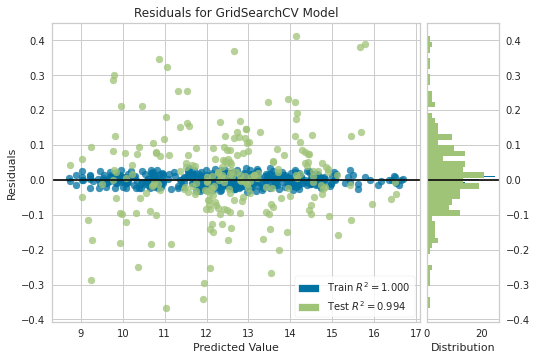

In [12]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'residuals_ml_model.png')
visualizer.show(outpath=save_to)

<AxesSubplot:title={'center':'Prediction Error for GridSearchCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

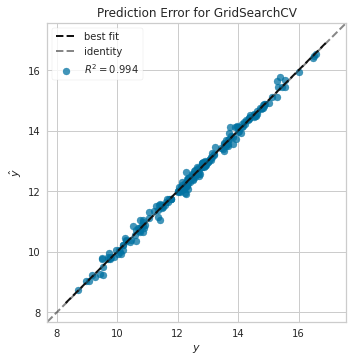

In [13]:
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'prediction_errors_ml_model.png')
visualizer.show(outpath=save_to)

In [14]:
n_points = 100
X_set = X_test.sample(n_points)

X_set = shap.sample(X_test, n_points)

In [15]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test.columns)
    return model.best_estimator_.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, data=X_set.values, feature_names = x_labels, algorithm = 'auto')
shap_values = explainer.shap_values(X_set)



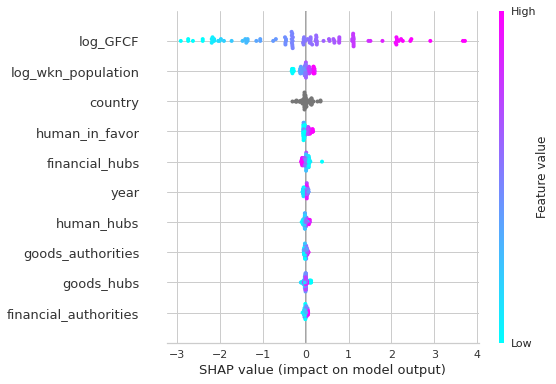

In [16]:
shap.summary_plot(shap_values, X_set, show=False, cmap=plt.get_cmap("cool"))

save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_values_levels.png')
plt.tight_layout()
plt.savefig(save_to)    
plt.show()

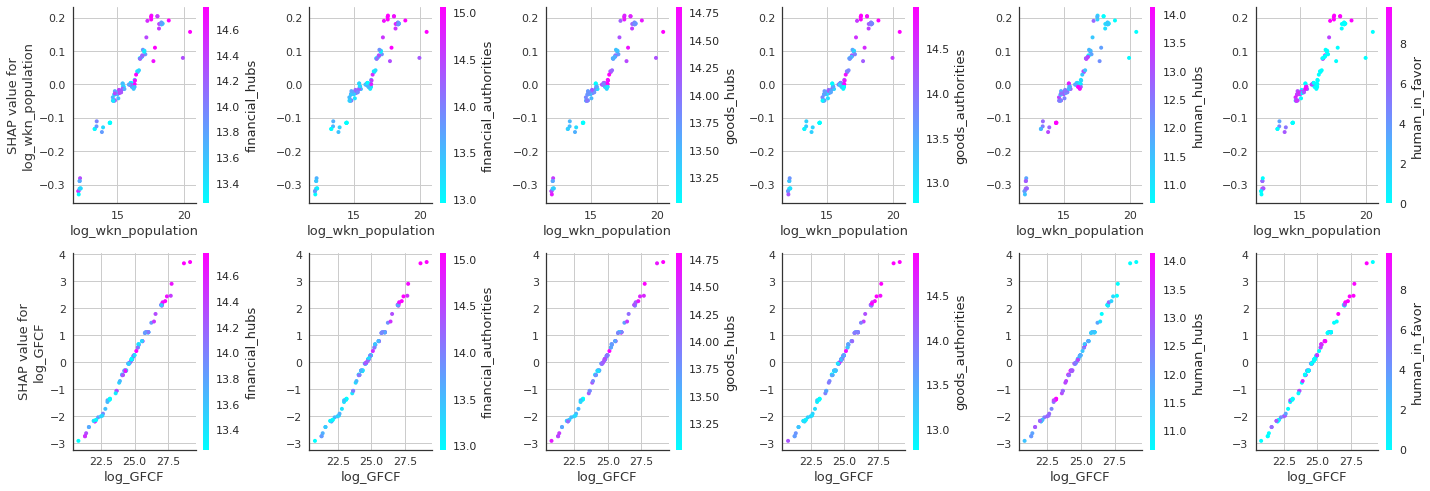

In [17]:
fig, ax = plt.subplots(2,6, sharey='row', figsize=(20,7))

for i, var in enumerate(reduced_terms_list):
    for j, factor in enumerate(['log_wkn_population', 'log_GFCF']):
        shap.dependence_plot(factor, shap_values, X_set, interaction_index=var, ax=ax[j][i], cmap=plt.get_cmap("cool"), show=False)
        if i!=0:
            ax[j][i].set_ylabel('')

plt.tight_layout()        
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'shap_dependence_plots.png')
plt.savefig(save_to)    
plt.show()